In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import zipfile

In [18]:
# Defining the test paths
test_file_path ='/kaggle/input/pytorch-train-test/test_ScVgIM0/test.csv'
train_file_path = '/kaggle/input/pytorch-train-test/train_LbELtWX/train.csv'


In [19]:
# Creating the dataframe
train_df = pd.read_csv(train_file_path)
test_df= pd.read_csv(test_file_path)

In [20]:
train_df.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [25]:
# loading training images
train_img = []
for img_name in tqdm(train_df['id']):
    # defining the image path
    image_path = '/kaggle/input/pytorch-train-test/train_LbELtWX/train/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)



100%|██████████| 60000/60000 [02:07<00:00, 470.91it/s]


(60000, 28, 28)

In [37]:
# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train_df['label'].values
train_x.shape

(60000, 28, 28)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fbade47cbd0>)

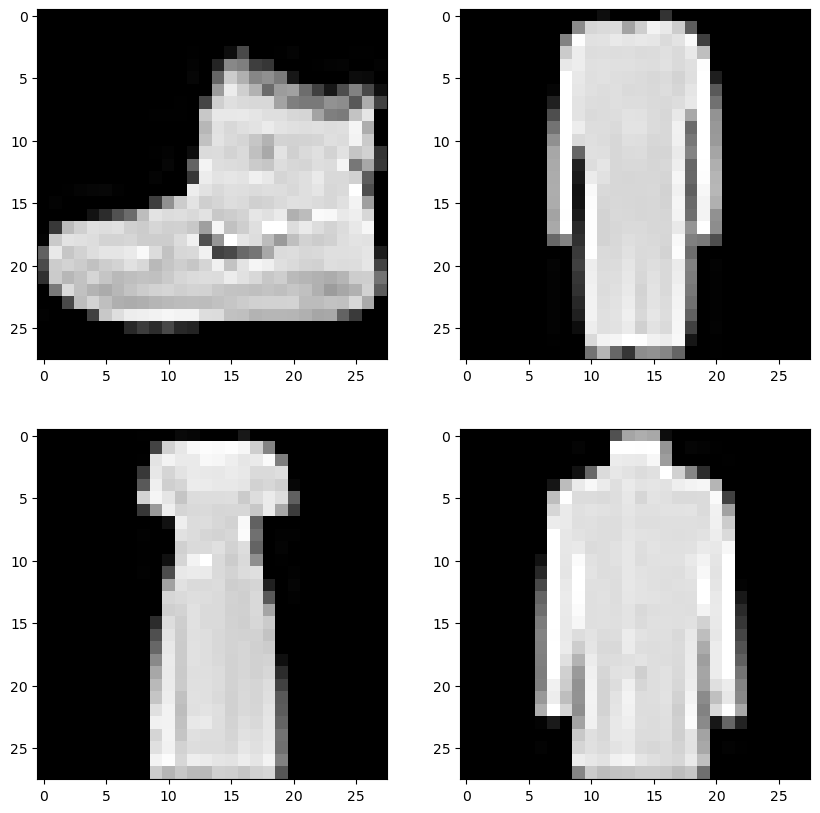

In [38]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [39]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [40]:

# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [41]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [53]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [54]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()

    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [55]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [56]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.3943, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(2.6675, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.9686, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.2831, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.0268, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.0625, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.0288, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.9261, grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(0.7898, grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(0.8004, grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(0.7744, grad_fn=<NllLossBackward0>)
Epoch :  23 	 loss : tensor(0.7289, grad_fn=<NllLossBackward0>)
Epoch :  25 	 loss : tensor(0.7259, grad_fn=<NllLossBackward0>)


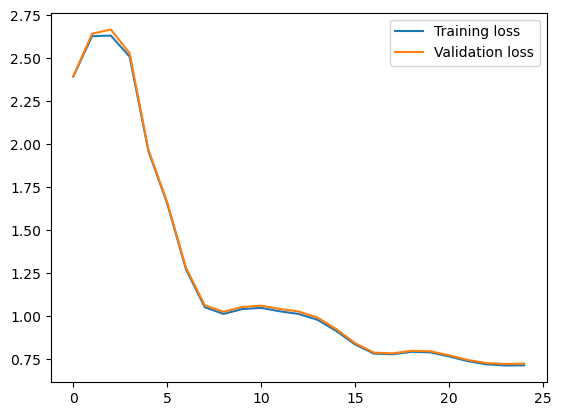

In [60]:
# plotting the training and validation loss
with torch.no_grad():
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()

In [62]:
# prediction for training set
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.7396296296296296

In [63]:

# prediction for validation set
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.7381666666666666

In [67]:
# loading test images
test_img = []
for img_name in tqdm(test_df['id']):
    # defining the image path
    image_path = '/kaggle/input/pytorch-train-test/test_ScVgIM0/test/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    test_img.append(img)

# converting the list to numpy array
test_x = np.array(test_img)
test_x.shape

100%|██████████| 10000/10000 [01:12<00:00, 138.73it/s]


(10000, 28, 28)

In [68]:

# converting training images into torch format
test_x = test_x.reshape(10000, 1, 28, 28)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([10000, 1, 28, 28])

In [70]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [71]:
# replacing the label with prediction
sample_submission['label'] = predictions
sample_submission.head()

NameError: name 'sample_submission' is not defined

In [72]:
# saving the file
sample_submission.to_csv('submission.csv', index=False)

NameError: name 'sample_submission' is not defined